# Классификация спама

In [1]:
import copy

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report

import numpy as np

import matplotlib.pyplot as plt
from IPython.display import clear_output

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW


import transformers
from transformers import AutoModel, AutoTokenizer

from torchinfo import summary

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'CPU'
RANDOM_STATE=2024

## 1. Загрузка датасета и обработка данных

In [3]:
df = pd.read_csv('/kaggle/input/vk-spam/train_spam.csv')

In [4]:
df.head()

,text_type,text
0,ham,make sure alex knows his birthday is over in f...
1,ham,a resume for john lavorato thanks vince i will...
2,spam,plzz visit my website moviesgodml to get all m...
3,spam,urgent your mobile number has been awarded wit...
4,ham,overview of hr associates analyst project per ...


In [5]:
df['target'] = df['text_type'].apply(lambda x: 1 if x == 'spam' else 0)

In [6]:
df.isnull().sum()

text_type    0
text         0
target       0
dtype: int64

In [8]:
df['target'].value_counts()

target
0    11469
1     4809
Name: count, dtype: int64

**Разделим данные на train, validation и test, не забывая про стратификацию:**

In [10]:
df_train, df_val = train_test_split(df, stratify=df['target'],
                                    test_size=0.2, random_state=RANDOM_STATE, shuffle=True)
df_val, df_test = train_test_split(df_val, stratify=df_val['target'],
                                   test_size=0.4, random_state=RANDOM_STATE, shuffle=True)

**Создадим кастомный класс для нашего датасета:**

In [12]:
class ProblemsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, item):
        text = self.texts[item]
        label = self.labels[item]
        
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length = self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

**Функция для создания DataLoader:**

In [13]:
def create_dataloader(data, tokenizer_name, batch_size):
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
    dataset = ProblemsDataset(data['text'].to_numpy(), data.target.to_numpy(), tokenizer)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

## 2. Кастомный класс для модели трансформера

In [24]:
N_CLASSES = 2

In [25]:
class TransformerClassificationModel(nn.Module):
    def __init__(self, base_transformer_model):
        super(TransformerClassificationModel, self).__init__()
        self.backbone = AutoModel.from_pretrained(base_transformer_model)
        self.drop = nn.Dropout(p=0.3)
        self.nonlin = nn.ReLU()
        self.linear = nn.Linear(self.backbone.config.hidden_size, self.backbone.config.hidden_size)
        self.out = nn.Linear(self.backbone.config.hidden_size, N_CLASSES)

    def forward(self, input_ids, attention_mask):
        pooled_output = self.backbone(
            input_ids=input_ids,
            attention_mask=attention_mask
        )[1]
        outputs = self.drop(pooled_output)
        outputs = self.nonlin(self.linear(outputs))
        outputs = self.out(outputs)
        return outputs

**Напишем функцию для заморозка backbone:**

In [26]:
def freeze_backbone_function(model: TransformerClassificationModel):
    for param in model.backbone.parameters():
        param.requires_grad = False
    pass

## 3. Функция для дообучения:

**Основная функция для обучения:**

In [27]:
def train_transformer(model, train_dataloader, val_dataloader,
                      num_epochs, freeze_backbone=True):
    # копируем модель и переносим на device
#    model = copy.copy(transformer_model).to(device)
    model.to(device)
    # замораживаем слои backbone
    if freeze_backbone:
        freeze_backbone_function(model)
    
    optimizer = AdamW(model.parameters(), lr=2e-5)
    loss_fn = nn.CrossEntropyLoss().to(device)
    
    history = {"train_loss": [], "train_acc": [], "val_loss": [],
               "val_acc": [], "train_f1": [], "val_f1": []}
    
    # по f1 будем определять какую модель сохранять
    best_f1 = 0
    
    for i in range(num_epochs):
        
        # train epoch
        f1, accuracy, loss = train_epoch(model, train_dataloader, loss_fn, optimizer, device)
        history['train_loss'].append(loss)
        history['train_acc'].append(accuracy)
        history['train_f1'].append(f1)
        
        # eval epoch
        f1, accuracy, loss = eval_model(model, val_dataloader, loss_fn, device)
        history['val_loss'].append(loss)
        history['val_acc'].append(accuracy)
        history['val_f1'].append(f1)
        
        # сохраняем модель
        if history['val_f1'][-1] > best_f1:
            best_f1 = history['val_f1'][-1]
            torch.save(model.state_dict(), 'model.bin')
        
        # изображаем графики
        draw_res(history)
    
    # загружаем веса лучшей модели        
    model.load_state_dict(torch.load('model.bin'))
    
    return model, history

In [28]:
def train_epoch(model, data_loader, loss_fn,
                optimizer, device):
    
    model = model.train()
    
    losses = []
    correct_predictions = 0
    f1 = 0
    
    for d in data_loader:
        input_ids = d['input_ids'].to(device)
        attention_mask = d['attention_mask'].to(device)
        labels = d['labels'].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        preds = torch.max(outputs, dim=1)[1]
        loss = loss_fn(outputs, labels)
        
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.cpu().item())
        f1 += f1_score(labels.cpu().numpy(), preds.cpu().numpy(), average='weighted')
        
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        optimizer.zero_grad()
    
    batch_size = len(next(iter(data_loader))['labels'])
    
    return f1/len(losses), correct_predictions.double().cpu().item() / (len(losses) * batch_size), np.mean(losses)

In [29]:
def eval_model(model, data_loader, loss_fn, device):
    model = model.eval()
    
    losses = []
    correct_predictions = 0
    f1 = 0
    
    with torch.no_grad():
        for d in data_loader:
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            labels = d['labels'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask)
            
            preds = torch.max(outputs, dim=1)[1]
            loss = loss_fn(outputs, labels)
            
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.cpu().item())
            f1 += f1_score(labels.cpu().numpy(), preds.cpu().numpy(), average='weighted')
            
    
    batch_size = len(next(iter(data_loader))['labels'])
    
    return f1/len(losses), correct_predictions.double().cpu().item() / (len(losses)*batch_size), np.mean(losses)

**Функция для отрисовки графиков лосса, точности и f1 в процессе обучения:**

In [30]:
def draw_res(history):
    k = len(history["train_loss"])
    
    clear_output(wait=True)
    plt.figure(figsize=(18, 6))
        
    plt.subplot(1, 3, 1)
    plt.plot(np.arange(1, k+1), history["train_loss"], label='train loss')
    plt.plot(np.arange(1, k+1), history["val_loss"], label='val loss')
    plt.title('train / validation loss')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(np.arange(1, k+1), history["train_acc"], label='train acc')
    plt.plot(np.arange(1, k+1), history["val_acc"], label='val acc')
    plt.title('train / validation acc')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(np.arange(1, k+1), history["train_f1"], label='train f1')
    plt.plot(np.arange(1, k+1), history["val_f1"], label='val f1')
    plt.title('train / validation f1')
    plt.legend()

    plt.show()

**Функция для вывода classification report на тестовых данных:**

In [41]:
def test_model(model, data_loader, device):
    model = model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for d in data_loader:
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            y_true += d['labels'].tolist()[:]
            labels = d['labels'].to(device)
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask)
            y_pred += torch.max(outputs, dim=1)[1].cpu().tolist()[:]
            
    print(classification_report(y_true, y_pred))

## 4. Дообучение bert-tiny с замороженными и размороженными слоями:

In [32]:
model_name = 'prajjwal1/bert-tiny'

In [33]:
train_dataloader = create_dataloader(df_train, model_name, batch_size=16)
val_dataloader = create_dataloader(df_val, model_name, batch_size=16)
test_dataloader = create_dataloader(df_test, model_name, batch_size=16)

**Обучение с размороженными слоями:**

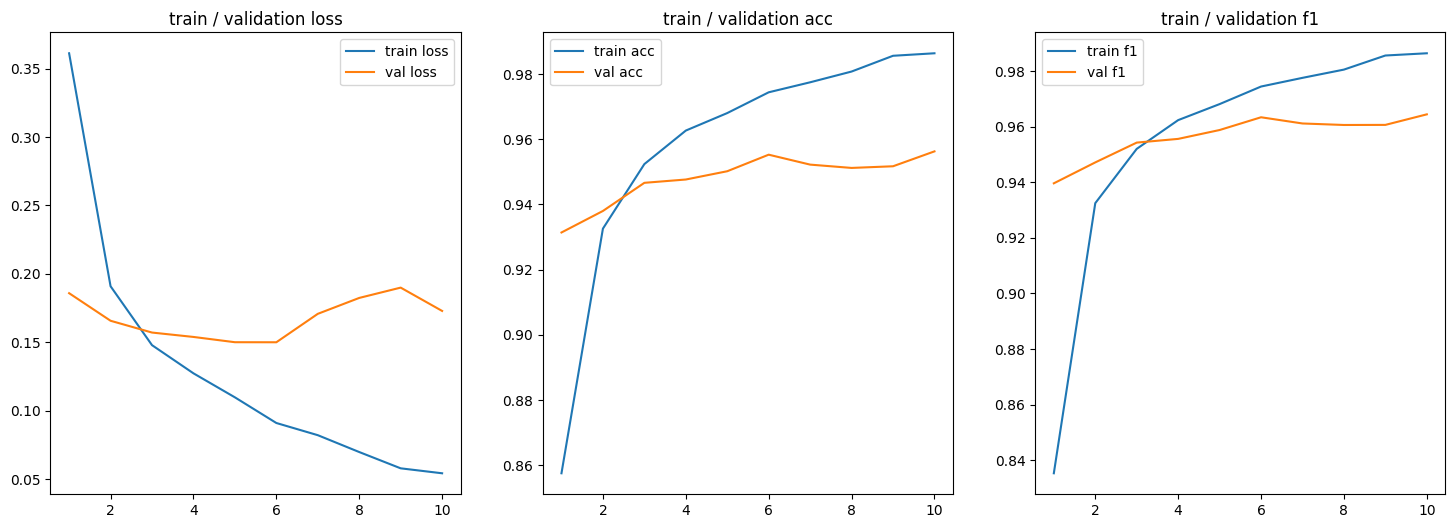

In [36]:
bert_transformer_model = TransformerClassificationModel(model_name);
bert_finetuned_with_unfreezed_backbone, history = train_transformer(bert_transformer_model,
                                                                  train_dataloader,
                                                                  val_dataloader,
                                                                  num_epochs=10,
                                                                  freeze_backbone=False)

In [42]:
test_model(bert_finetuned_with_unfreezed_backbone, test_dataloader, device)

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       918
           1       0.93      0.95      0.94       385

    accuracy                           0.96      1303
   macro avg       0.96      0.96      0.96      1303
weighted avg       0.96      0.96      0.96      1303

